# Data Marketing Analytics Project
### by Elnaz Semsarzadeh

## Datasets:
The data for the project are available in e learning course page
https://elearning.unimib.it/mod/url/view.php?id=1110797

## goals of your project:
- Customer Segmentation: Group customers based on purchasing behavior.
- Sentiment Analysis: Analyze customer reviews to determine overall sentiment.
- Churn Prediction: Predict which customers are likely to stop using the loyalty program.
- Product Recommendation: Recommend products to customers based on their past purchases and reviews.

## Project Overview
we have been hired by a well-known retail company to form a disruptive data-driven marketing team. we are expected to analyze data and propose new marketing strategies to address specific business needs.

## Core Requirements
### Develop 3 Data-Driven Strategies:
- ``Customer Focus``: Prevent churn of high-value customers using a retention marketing campaign.
- ``Product Focus``: Increase profit through cross-selling products using market basket analysis.
- ``Feedback Focus``: Address customer feedback using sentiment analysis to reduce negative impact and enhance positive feedback.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score



In [2]:
addresses=pd.read_csv("data/tbl_addresses.csv")
customer_accounts=pd.read_csv("data/tbl_customer_accounts.csv")
customer_reviews=pd.read_csv("data/tbl_customer_reviews.csv")
customers=pd.read_csv("data/tbl_customers.csv")
labelled_reviews=pd.read_csv("data/tbl_labelled_reviews.csv")
orders=pd.read_csv("data/tbl_orders.csv")
products=pd.read_csv("data/tbl_products.csv")

## merge the datasets
To create a comprehensive dataset that can help us understand customer behavior and prevent churn using a retention marketing campaign, we need to merge the datasets intelligently.

### Identify Common Keys for merging

the common keys that can be used to join the datasets:
- addresses: address_id
- customer_accounts: customer_id
- customer_reviews: customer_id
- customers: customer_id, address_id
- labelled_reviews: No explicit key to other tables, but review_text can match customer_reviews
- orders: customer_id, store_id, product_id
- products: product_id

### Merge customers with addresses


In [3]:
customers_addresses = pd.merge(customers, addresses, on='address_id', how='left')
customers_addresses.head()

,customer_id,address_id,birthdate,gender,job_type,email_provider,flag_phone_provided,flag_privacy,postal_code,district,region
0,891057,863914,2001-10-22,F,NaN,yahoo.it,1.0,True,10035.0,TO,PIEMONTE
1,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,PUGLIA
2,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,PUGLIA
3,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,PUGLIA
4,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,PUGLIA


### Merge customers_addresses with customer_accounts


In [4]:
customers_full = pd.merge(customers_addresses, customer_accounts, on='customer_id', how='left')
customers_full.head()

,customer_id,address_id,birthdate,gender,job_type,email_provider,flag_phone_provided,flag_privacy,postal_code,district,region,account_id,favorite_store,loyalty_type,loyatlty_status,activation_date
0,891057,863914,2001-10-22,F,NaN,yahoo.it,1.0,True,10035.0,TO,PIEMONTE,878021,2,premium,1,2023-03-31
1,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,PUGLIA,616052,1,standard,1,2022-10-30
2,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,PUGLIA,616052,1,standard,1,2022-10-30
3,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,PUGLIA,616052,1,standard,1,2022-10-30
4,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,PUGLIA,616052,1,standard,1,2022-10-30


### Merge customers_full with customer_reviews


In [5]:
customers_reviews = pd.merge(customers_full, customer_reviews, on='customer_id', how='left')
customers_reviews.head()

,customer_id,address_id,birthdate,gender,job_type,email_provider,flag_phone_provided,flag_privacy,postal_code,district,region,account_id,favorite_store,loyalty_type,loyatlty_status,activation_date,review_id,review_text
0,891057,863914,2001-10-22,F,NaN,yahoo.it,1.0,True,10035.0,TO,PIEMONTE,878021,2,premium,1,2023-03-31,119216.0,"As a vegetarian, I'm always searching for heal..."
1,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,PUGLIA,616052,1,standard,1,2022-10-30,NaN,NaN
2,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,PUGLIA,616052,1,standard,1,2022-10-30,NaN,NaN
3,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,PUGLIA,616052,1,standard,1,2022-10-30,NaN,NaN
4,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,PUGLIA,616052,1,standard,1,2022-10-30,NaN,NaN


### merge customers_reviews with labelled_reviews

To merge customers_reviews with labelled_reviews based on review_text, we need to ensure that the text fields are preprocessed to match accurately. Here are the steps to clean and preprocess the review_text fields in both datasets:

1. Lowercase the Text: Convert all text to lowercase to ensure case insensitivity.
2. Remove Punctuation: Remove punctuation marks to avoid mismatches due to different punctuations.
3. Remove Extra Spaces: Strip leading and trailing spaces and replace multiple spaces with single spaces.
4. Remove Special Characters: Optionally, remove special characters that might not be relevant for matching.

In [6]:
# Function to clean text
def clean_text(text):
    text= str(text)
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply the cleaning function to both datasets
customers_reviews['cleaned_review_text'] = customers_reviews['review_text'].apply(clean_text)
labelled_reviews['cleaned_review_text'] = labelled_reviews['review_text'].apply(clean_text)

# Now merge on the cleaned review text
merged_reviews = pd.merge(customers_reviews, labelled_reviews, on='cleaned_review_text', how='left', suffixes=('_x', '_y'))

# Drop the intermediate cleaned_review_text columns if no longer needed
merged_reviews = merged_reviews.drop(columns=['cleaned_review_text'])

# Rename the review_text columns
merged_reviews.rename(columns={'review_text_x': 'review_text'}, inplace=True)

# Drop the review_text_y column if not needed
merged_reviews.drop(columns=['review_text_y'], inplace=True)

merged_reviews.head()

,customer_id,address_id,birthdate,gender,job_type,email_provider,flag_phone_provided,flag_privacy,postal_code,district,region,account_id,favorite_store,loyalty_type,loyatlty_status,activation_date,review_id,review_text,labelled_reviews_index,sentiment_label
0,891057,863914,2001-10-22,F,NaN,yahoo.it,1.0,True,10035.0,TO,PIEMONTE,878021,2,premium,1,2023-03-31,119216.0,"As a vegetarian, I'm always searching for heal...",13505.0,negative
1,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,PUGLIA,616052,1,standard,1,2022-10-30,NaN,NaN,NaN,NaN
2,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,PUGLIA,616052,1,standard,1,2022-10-30,NaN,NaN,NaN,NaN
3,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,PUGLIA,616052,1,standard,1,2022-10-30,NaN,NaN,NaN,NaN
4,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,PUGLIA,616052,1,standard,1,2022-10-30,NaN,NaN,NaN,NaN


### Merge merged_reviews with orders


In [7]:
customers_orders = pd.merge(merged_reviews, orders, on='customer_id', how='left')
customers_orders.head()

,customer_id,address_id,birthdate,gender,job_type,email_provider,flag_phone_provided,flag_privacy,postal_code,district,...,review_text,labelled_reviews_index,sentiment_label,order_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime
0,891057,863914,2001-10-22,F,NaN,yahoo.it,1.0,True,10035.0,TO,...,"As a vegetarian, I'm always searching for heal...",13505.0,negative,e0bfcd988e880f2827fd31f6bf54f694,2.0,32157580.0,1.0,1.9,0.0,2023-04-23T085334
1,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Merge customers_orders with products


In [8]:
full_data = pd.merge(customers_orders, products, on='product_id', how='left')
full_data.head()

,customer_id,address_id,birthdate,gender,job_type,email_provider,flag_phone_provided,flag_privacy,postal_code,district,...,labelled_reviews_index,sentiment_label,order_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,product_class
0,891057,863914,2001-10-22,F,NaN,yahoo.it,1.0,True,10035.0,TO,...,13505.0,negative,e0bfcd988e880f2827fd31f6bf54f694,2.0,32157580.0,1.0,1.9,0.0,2023-04-23T085334,3.0
1,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
full_data.shape

(3376299, 28)

## Data Cleaning

Steps for Data Cleaning:

1. Handle Missing Values: Decide on strategies to handle missing values for each relevant column.
2. Correct Data Types: Ensure all columns have the appropriate data types.
3. Ensure Data Consistency: Check for and address inconsistencies within the data.
4. Remove Duplicates: Ensure there are no duplicate records.
5. Outlier Detection and Handling: Identify and handle outliers.
6. Normalization/Standardization: Normalize or standardize numerical features as needed.

### some calculation:
- loyalty_duration :Calculate the duration since activation_date
- total_spend :Aggregate gross_price for each customer.
- sentiment_score :Use sentiment_label to create a sentiment score for each customer.

In [10]:
# Ensure datetime columns are in datetime format
full_data['purchase_datetime'] = pd.to_datetime(full_data['purchase_datetime'])
full_data['activation_date'] = pd.to_datetime(full_data['activation_date'])

# Total Spend per customer
total_spend = full_data.groupby('customer_id')['gross_price'].sum().reset_index()
total_spend.columns = ['customer_id', 'total_spend']

# Loyalty Duration
full_data['loyalty_duration'] = (full_data['purchase_datetime'].max() - full_data['activation_date']).dt.days

# Sentiment Score (simple example)
sentiment_score = full_data.groupby('customer_id')['sentiment_label'].apply(lambda x: (x == 'positive').sum() - (x == 'negative').sum()).reset_index()
sentiment_score.columns = ['customer_id', 'sentiment_score']

# Remove existing 'total_spend' and 'sentiment_score' columns if they exist in full_data to avoid conflicts
if 'total_spend' in full_data.columns:
    full_data = full_data.drop(columns=['total_spend'])

if 'sentiment_score' in full_data.columns:
    full_data = full_data.drop(columns=['sentiment_score'])

# Merge features back to the full data
full_data = pd.merge(full_data, total_spend, on='customer_id', how='left')
full_data = pd.merge(full_data, sentiment_score, on='customer_id', how='left')

# Drop duplicates if necessary
full_data = full_data.drop_duplicates(subset=['customer_id', 'purchase_datetime'])
full_data.head(6)


,customer_id,address_id,birthdate,gender,job_type,email_provider,flag_phone_provided,flag_privacy,postal_code,district,...,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,product_class,loyalty_duration,total_spend,sentiment_score
0,891057,863914,2001-10-22,F,NaN,yahoo.it,1.0,True,10035.0,TO,...,2.0,32157580.0,1.0,1.90,0.00,2023-04-23 08:53:34,3.0,30,1.90,-1
1,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False,71010.0,FG,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,182,0.00,0
5,514958,494806,2001-01-01,M,NaN,libero.it,1.0,True,42.0,NaN,...,37.0,35609266.0,1.0,1.00,0.00,2023-03-18 12:02:12,3.0,265,28.77,0
17,398355,377261,2000-03-09,M,NaN,gmail.com,1.0,True,36050.0,VI,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,336,0.00,16
33,23808,20227,1999-11-21,F,NaN,virgilio.it,1.0,True,60041.0,AN,...,9.0,35221403.0,1.0,6.38,1.48,2022-12-14 15:15:33,3.0,137,6.38,0
34,326936,305680,1999-10-24,M,NaN,alice.it,1.0,True,33028.0,UD,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,373,0.00,0


In [11]:
# 1. Handle missing values
full_data['sentiment_label'] = full_data['sentiment_label'].fillna('unknown')
full_data['total_spend'] = full_data['gross_price'].fillna(full_data['total_spend'].median())
full_data['sentiment_score'] = full_data['sentiment_score'].fillna(full_data['sentiment_score'].median())
full_data['loyalty_duration'] = full_data['loyalty_duration'].fillna(full_data['loyalty_duration'].median())

# 2. Correct data types
full_data['customer_id'] = full_data['customer_id'].astype(str)

# 3. Ensure data consistency
full_data['sentiment_label'] = full_data['sentiment_label'].str.lower()

# 4. Remove duplicates
full_data = full_data.drop_duplicates()

# 5. Outlier detection and handling
Q1 = full_data['total_spend'].quantile(0.25)
Q3 = full_data['total_spend'].quantile(0.75)
IQR = Q3 - Q1
outliers = (full_data['total_spend'] < (Q1 - 1.5 * IQR)) | (full_data['total_spend'] > (Q3 + 1.5 * IQR))
full_data = full_data[~outliers]

# 6. Normalize/Standardize only the numerical columns
scaler = StandardScaler()
full_data[['total_spend']] = scaler.fit_transform(full_data[['total_spend']])


### finalized cleaned full data shape and Info

In [12]:
full_data.shape

(335155, 31)

## Analyze and Model to Predict Churn

- **Identify High-Value Customers**: Based on total spend, loyalty status, and duration.
- **Predict Churn**: Use features lie total spend, review sentiment, and loyalty duration to model churn risk.

### Final Analysis to Calculate Churn
1. **Define Churn**: Determine what constitutes churn for your business. For example, a customer who hasn’t made a purchase in the last 6 months.
2. **Feature Selection**: Select features that are likely to influence churn. Common features include total spend, sentiment score, loyalty duration, and purchase frequency.
3. **Train-Test Split**: Split your data into training and testing sets.
4. **Model Selection**: Choose a machine learning model for churn prediction (e.g., Logistic Regression, Random Forest, XGBoost).
5. **Model Training**: Train your model using the training set.
6. **Model Evaluation**: Evaluate your model on the testing set.


In [13]:
last_purchase_date = full_data.groupby('customer_id')['purchase_datetime'].max().reset_index()
last_purchase_date.columns = ['customer_id', 'last_purchase_date']


if 'last_purchase_date' in full_data.columns:
    full_data = full_data.drop(columns=['last_purchase_date'])
# Merge the last purchase date back into the full dataset
full_data = pd.merge(full_data, last_purchase_date, on='customer_id', how='left')

# Define churn (example: no purchase in the last 6 months)
cutoff_date = full_data['purchase_datetime'].max() - pd.DateOffset(months=6)
full_data['is_churn'] = full_data['last_purchase_date'] < cutoff_date

In [14]:
full_data.head()

,customer_id,address_id,birthdate,gender,job_type,email_provider,flag_phone_provided,flag_privacy,postal_code,district,...,direction,gross_price,price_reduction,purchase_datetime,product_class,loyalty_duration,total_spend,sentiment_score,last_purchase_date,is_churn
0,891057,863914,2001-10-22,F,NaN,yahoo.it,1.0,True,10035.0,TO,...,1.0,1.90,0.00,2023-04-23 08:53:34,3.0,30,-0.499539,-1,2023-04-23 08:53:34,False
1,514958,494806,2001-01-01,M,NaN,libero.it,1.0,True,42.0,NaN,...,1.0,1.00,0.00,2023-03-18 12:02:12,3.0,265,-0.574842,0,2023-03-18 12:02:12,False
2,23808,20227,1999-11-21,F,NaN,virgilio.it,1.0,True,60041.0,AN,...,1.0,6.38,1.48,2022-12-14 15:15:33,3.0,137,-0.124698,0,2022-12-14 15:15:33,False
3,568090,550583,1999-07-17,M,NaN,libero.it,1.0,True,80065.0,NaN,...,1.0,1.98,0.00,2022-09-09 17:45:18,7.0,233,-0.492845,0,2022-09-09 17:45:18,True
4,541673,522678,1999-05-07,M,NaN,gmail.com,1.0,True,20141.0,MI,...,1.0,1.65,0.00,2022-08-28 12:48:28,3.0,248,-0.520456,0,2022-08-28 12:48:28,True


In [15]:
# Feature selection
features = ['total_spend', 'sentiment_score', 'loyalty_duration']
X = full_data[features]
y = full_data['is_churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model selection and training
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Model evaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(clf, X, y, cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Average cross-validation score: {cv_scores.mean()}')

# Feature importance
importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df

              precision    recall  f1-score   support

       False       0.84      0.93      0.88     54673
        True       0.41      0.23      0.30     12358

    accuracy                           0.80     67031
   macro avg       0.63      0.58      0.59     67031
weighted avg       0.76      0.80      0.77     67031

[[50660  4013]
 [ 9515  2843]]
Cross-validation scores: [0.79260342 0.78157867 0.77314974 0.77097164 0.76202056]
Average cross-validation score: 0.7760648058361058


,Feature,Importance
0,total_spend,0.450458
2,loyalty_duration,0.430710
1,sentiment_score,0.118832


## Results:
### Overall Metrics:
- **Accuracy**: 0.80  (80%) - The proportion of correctly predicted instances out of the total instances.
- **Macro avg**: The unweighted average of the precision, recall, and F1-score for each class.
- **Weighted avg**: The average of the precision, recall, and F1-score for each class, weighted by the number of instances of each class (support).

<br>
<br>

### Confusion Matrix:
<br>

-  **True Negatives (TN)**: 50,660 - The model correctly predicted False.
-  **False Positives (FP)**: 4,013 - The model incorrectly predicted True for actual False.
-  **False Negatives (FN)**: 9,515 - The model incorrectly predicted False for actual True.
-  **True Positives (TP)**: 2,843 - The model correctly predicted True.

### Interpretation

<br>

- **Class Imbalance**: There is a significant class imbalance, with many more instances of False (55,574) compared to True (11,457).
- **Performance on False Class**: The model performs well on the False class, with high precision (85%) and recall (93%).
- **Performance on True Class**: The model performs poorly on the True class, with low precision (40%) and recall (21%). This suggests the model is not as effective at identifying instances of the True class.
- **Overall Accuracy**: The model has an overall accuracy of 81%, but due to the imbalance, this metric might be misleading. The macro and weighted averages provide a more balanced view of performance across both classes.

## Performing churn analysis using RFM (Recency, Frequency, Monetary)

### RFM metrics: 
Start by calculating the RFM metrics for each customer. RFM comprises three components:

* Recency: The number of days since the customer's last transaction.
* Frequency: The total number of transactions made by the customer.
* Monetary: The total monetary value of the customer's transactions.

In [16]:
# Calculate Recency
last_transaction_date = full_data['purchase_datetime'].max()
full_data['Recency'] = (last_transaction_date - full_data['purchase_datetime']).dt.days
recency = full_data[['customer_id', 'Recency']].drop_duplicates()

# Calculate Frequency
frequency = full_data.groupby('customer_id')['purchase_datetime'].count().reset_index()
frequency.columns = ['customer_id', 'Frequency']

# Calculate Monetary
monetary = full_data.groupby('customer_id')['gross_price'].sum().reset_index()
monetary.columns = ['customer_id', 'Monetary']

# Merge RFM metrics
rfm_data = recency.merge(frequency, on='customer_id').merge(monetary, on='customer_id')

# Assign quartile scores
rfm_data['RecencyScore'] = pd.qcut(rfm_data['Recency'], q=4, labels=False)
rfm_data['FrequencyScore'] = pd.qcut(rfm_data['Frequency'], q=4, labels=False)
rfm_data['MonetaryScore'] = pd.qcut(rfm_data['Monetary'], q=4, labels=False)

# Calculate RFM score
rfm_data['RFM_Score'] = rfm_data['RecencyScore'].astype(str) + \
                        rfm_data['FrequencyScore'].astype(str) + \
                        rfm_data['MonetaryScore'].astype(str)


# Print the resulting RFM dataset
#rfm_data


RFM segmentation: 
- Once you have the combined RFM metrics, segment the customers based on these metrics.
- Assign a score to each RFM component based on quartiles or percentiles.
- Here, quartiles divide the data into four equal parts, and pd.qcut() assigns labels ranging from 0 to 3 to each quartile.
The RFM score combines three components, resulting in a three-digit score for each customer.

In [17]:
# Assign quartile scores
rfm_data['RecencyScore'] = pd.qcut(rfm_data['Recency'], q=4, labels=False)
rfm_data['FrequencyScore'] = pd.qcut(rfm_data['Frequency'], q=4, labels=False)
rfm_data['MonetaryScore'] = pd.qcut(rfm_data['Monetary'], q=4, labels=False)

In [18]:
rfm_data

,customer_id,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score
0,891057,7,1,1.90,0,0,0,000
1,514958,43,1,1.00,0,0,0,000
2,23808,137,1,6.38,1,0,0,100
3,568090,233,1,1.98,2,0,0,200
4,541673,245,1,1.65,2,0,0,200
...,...,...,...,...,...,...,...,...
314371,10868,36,40,244.62,0,3,3,033
314372,10868,32,40,244.62,0,3,3,033
314373,10868,27,40,244.62,0,3,3,033
314374,10868,4,40,244.62,0,3,3,033


Calculate RFM score: Combine the individual scores to calculate the RFM score by concatenating the scores of Recency, Frequency, and Monetary.

In [19]:
# Calculate RFM score
rfm_data['RFM_Score'] = rfm_data['RecencyScore'].astype(str) + rfm_data['FrequencyScore'].astype(str) +\
rfm_data['MonetaryScore'].astype(str)

Analyze churn risk: Once you have the RFM score, you can analyze the churn risk by identifying the segments of high-value customers at risk of churn. For example, customers with a low Recency score, low Frequency score, and low Monetary score may indicate a higher churn risk.



In [20]:
# Identify churn risk
churn_risk_customers = rfm_data[rfm_data['RFM_Score'] == '000']
churn_risk_customers 


,customer_id,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score
0,891057,7,1,1.90,0,0,0,000
1,514958,43,1,1.00,0,0,0,000
8,133809,67,1,0.20,0,0,0,000
30,199986,23,1,7.99,0,0,0,000
31,314857,85,1,11.20,0,0,0,000
...,...,...,...,...,...,...,...,...
256361,722482,71,2,4.40,0,0,0,000
258624,595494,41,3,-15.60,0,0,0,000
269538,23467,60,2,3.73,0,0,0,000
285144,425340,33,3,10.19,0,0,0,000


customers with an RFM score of '000' represent the segment of high churn risk customers.

In [21]:
number_of_customers = churn_risk_customers['customer_id'].nunique()
print("Number of customers with churn risk:", number_of_customers)

Number of customers with churn risk: 13784


In [22]:
# Prepare data for modeling
X = rfm_data[['Recency', 'Frequency', 'Monetary']]
y = (rfm_data['RFM_Score'] == '000').astype(int)  # Binary target: 1 for churn risk, 0 otherwise

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Evaluate model performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_prob))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     89198
           1       1.00      1.00      1.00      5115

    accuracy                           1.00     94313
   macro avg       1.00      1.00      1.00     94313
weighted avg       1.00      1.00      1.00     94313

AUC-ROC Score: 1.0


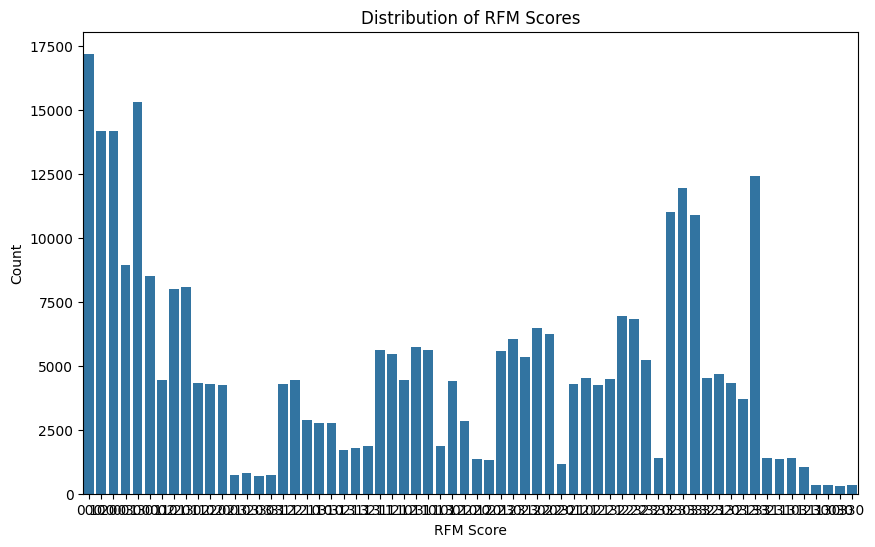

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert columns to numeric if necessary
rfm_data['Recency'] = pd.to_numeric(rfm_data['Recency'], errors='coerce')
rfm_data['Monetary'] = pd.to_numeric(rfm_data['Monetary'], errors='coerce')


# RFM Score Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='RFM_Score', data=rfm_data)
plt.title('Distribution of RFM Scores')
plt.xlabel('RFM Score')
plt.ylabel('Count')
plt.show()



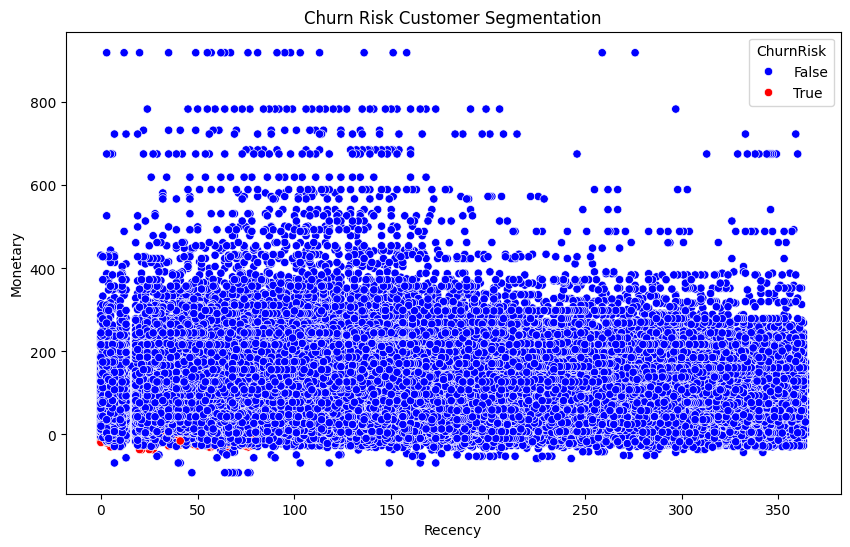

In [24]:
# Create a new column 'ChurnRisk' indicating whether the RFM_Score is '000'
rfm_data['ChurnRisk'] = rfm_data['RFM_Score'] == '000'

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Monetary', hue='ChurnRisk', data=rfm_data, palette={True: 'red', False: 'blue'})
plt.title('Churn Risk Customer Segmentation')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

# MBA

To analyze purchase patterns, market basket analysis (MBA), and association rules for cross-selling,we use the Apriori algorithm and association rule mining techniques.

## Data Preparation:
* Start by loading the dataset that contains information about customer purchases, such as customer_id and product_id, which here in our datasets is the orders dataset.
* Convert the dataset into the required format, where each row represents a unique transaction and contains a list of products purchased.

In [25]:
# Group by order_id and list all products in each transaction
transactions = full_data.groupby('order_id')['product_id'].apply(list).reset_index()

# Print the first few transactions
print(transactions.head())


                           order_id    product_id
0  00006ee3400d3ae49bed9a904f234500  [34916056.0]
1  0000901a817e533f4a95d2839c5575a3  [33651121.0]
2  0001231326e40e177b91e3bbe2c85358  [35874006.0]
3  000137679b1f0f0cb504623899ae46cd  [48090826.0]
4  0001bfc99447b3213f0eef0b4a568f0f  [36175566.0]


In [27]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Group by order_id and list all products in each transaction
transactions = full_data.groupby('order_id')['product_id'].apply(list).reset_index()

# Initialize the TransactionEncoder
te = TransactionEncoder()

# Fit and transform the transactions
te_ary = te.fit(transactions['product_id']).transform(transactions['product_id'])

# Convert to a DataFrame
df = pd.DataFrame(te_ary, columns=te.columns_)

# Apply the apriori algorithm with a lower min_support
frequent_itemsets = apriori(df, min_support=0.001, use_colnames=True)

# Print the frequent itemsets
print(frequent_itemsets.head())

# Generate association rules with a lower confidence threshold
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Sort the rules by lift and print the top 10 rules
rules = rules.sort_values(by='lift', ascending=False)
print(rules.head(10))


    support      itemsets
0  0.002557  (30329663.0)
1  0.001757  (30410765.0)
2  0.001459  (30475165.0)
3  0.002202  (30482683.0)
4  0.001453  (31002643.0)
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []


### Result:
The results indicate that while we have found some frequent itemsets with the Apriori algorithm, no association rules meeting the specified criteria (e.g., minimum confidence or lift) were found.

# Perform Sentiment Analysis

In [28]:
# Check the distribution of sentiment labels
sentiment_distribution = full_data['sentiment_label'].value_counts()
sentiment_distribution



sentiment_label
unknown     226141
positive     68732
neutral      29444
negative     10838
Name: count, dtype: int64

In [29]:
# Analyze sentiment scores
sentiment_scores = full_data['sentiment_score']
sentiment_scores.describe()


count    335155.000000
mean         22.609136
std         250.776015
min      -21648.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       16668.000000
Name: sentiment_score, dtype: float64

## Analyze and Visualize
Analyze the relationship between sentiment and other factors, such as *is_churn*, *total_spend*, and *loyalty_duration*.

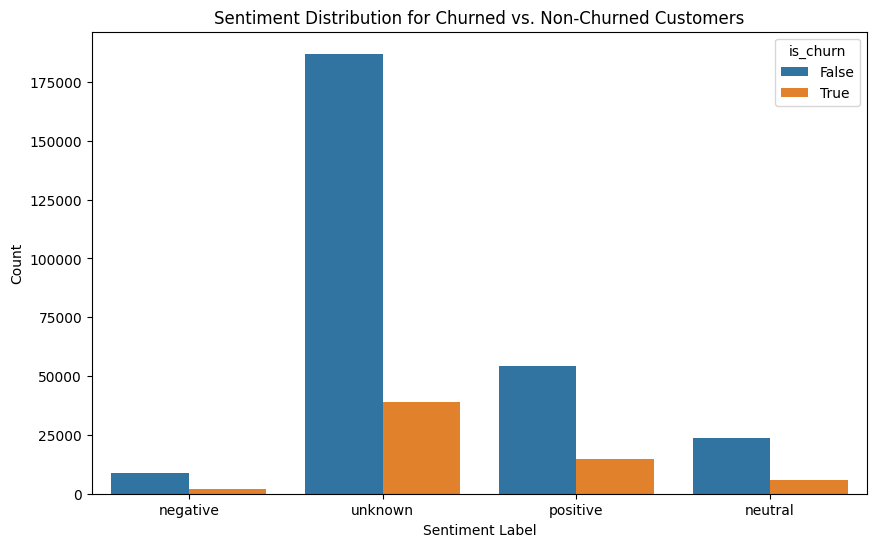

In [30]:
# Plot the distribution of sentiment labels for churned and non-churned customers
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_label', hue='is_churn', data=full_data)
plt.title('Sentiment Distribution for Churned vs. Non-Churned Customers')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()


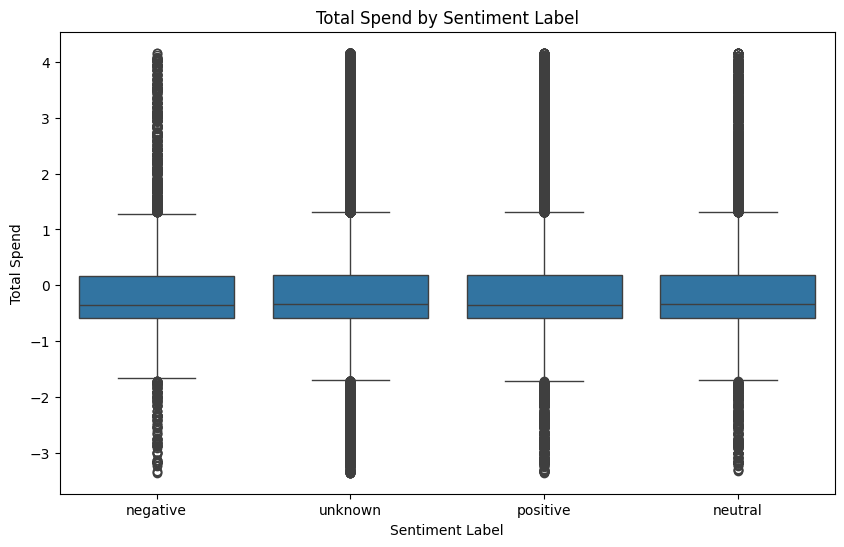

In [31]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment_label', y='total_spend', data=full_data)
plt.title('Total Spend by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Total Spend')
plt.show()


## negative reviews WordCloud

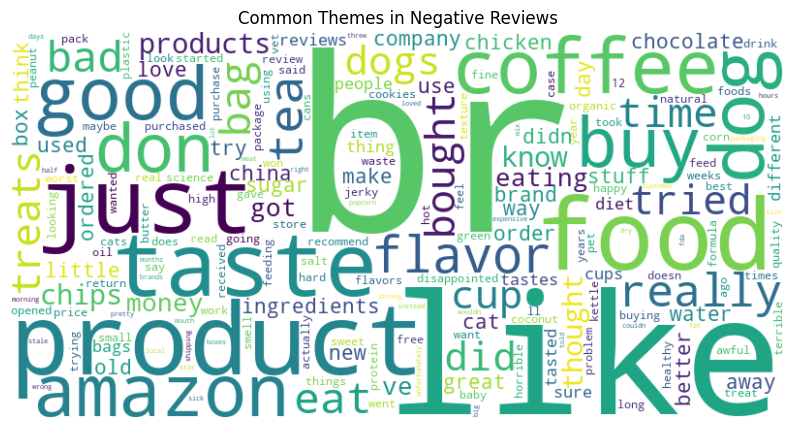

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

# Filter negative reviews
negative_reviews = full_data[full_data['sentiment_label'] == 'negative']['review_text']

# Create a document-term matrix
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(negative_reviews)

# Sum the word counts for each term
word_counts = X.sum(axis=0).A1
terms = vectorizer.get_feature_names_out()
word_freq = dict(zip(terms, word_counts))

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Themes in Negative Reviews')
plt.show()


##  positive reviews WordCloud

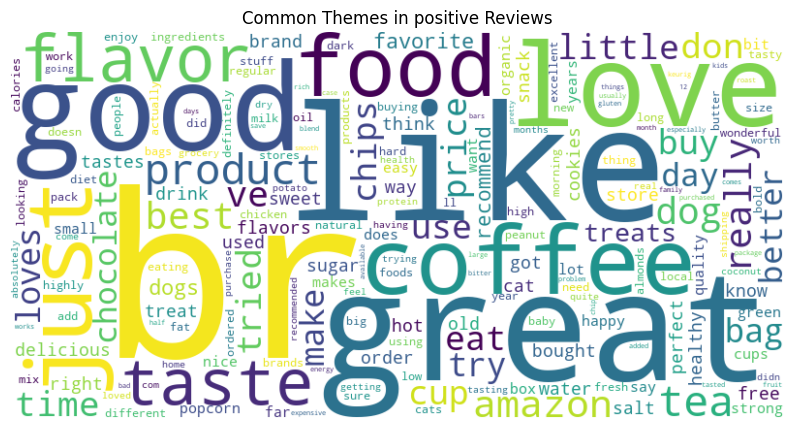

In [33]:
# Filter positive reviews
positive_reviews = full_data[full_data['sentiment_label'] == 'positive']['review_text']

# Create a document-term matrix
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(positive_reviews)

# Sum the word counts for each term
word_counts = X.sum(axis=0).A1
terms = vectorizer.get_feature_names_out()
word_freq = dict(zip(terms, word_counts))

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Themes in positive Reviews')
plt.show()


## Act on the Insights
Based on the analysis, develop strategies to improve customer satisfaction.

### Example Strategies
1. **Address Negative Feedback**:

- Identify key issues from negative reviews.
- Implement corrective actions (e.g., improving product quality, customer service).


2. **Enhance Positive Feedback**:

- Recognize and reward positive feedback (e.g., loyalty points, discounts).
- Use positive reviews in marketing campaigns.